In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import networkx as nx
import numpy as np
import cvxpy as cp
import json
import time
from tqdm import tqdm
from pathlib import Path

from src.load_data import (
    read_metadata_networks_tntp,
    read_graph_transport_networks_tntp,
    read_traffic_mat_transport_networks_tntp,
)
# from src.solvers.edge_based.min_cost_concurrent_flow import solve_min_cost_concurrent_flow

# from experiments.latency_vs_throughput.latency_vs_throughput import build_and_plot_latency_hist, get_flow_cost_and_amount, \
#     plot_latency_vs_throughput_pareto_front, scale_graph_bandwidth_and_cost, draw_graph_with_positions

from src.subgd import SDModel, subgd_mincost_mcf, ustm_mincost_mcf

import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'retina'

%matplotlib inline

In [3]:
from typing import Optional
def get_max_traffic_mat_mul(
    graph: nx.Graph, traffic_mat: np.ndarray, **solver_kwargs
) -> Optional[float]:
    graph = nx.DiGraph(graph)
    traffic_lapl = np.diag(traffic_mat.sum(axis=1)) - traffic_mat
    incidence_mat = nx.incidence_matrix(graph, oriented=True).todense()

    bandwidth = np.array(
        list(nx.get_edge_attributes(graph, "bandwidth").values()), dtype=np.float32
    )

    flow = cp.Variable((len(graph.edges), traffic_mat.shape[0]))
    gamma = cp.Variable()
    prob = cp.Problem(
        cp.Maximize(gamma),
        [
            cp.sum(flow, axis=1) <= bandwidth,
            (incidence_mat @ flow).T == -gamma * traffic_lapl,
            flow >= 0,
        ],
    )
    prob.solve(**solver_kwargs)

    if prob.status != "optimal":
        gamma = None

    gamma = gamma.value if flow is not None else None
    return gamma

In [4]:
networks_path = Path("./TransportationNetworks")
# network = "Anaheim"

# folder = "Anaheim"
# net_name = "Anaheim_net"
# traffic_mat_name = "Anaheim_trips"
    
# folder = "Barcelona"
# net_name = "Barcelona_net"
# traffic_mat_name = "Barcelona_trips"
    
folder = "SiouxFalls"
net_name = "SiouxFalls_net"
traffic_mat_name = "SiouxFalls_trips"
    
net_file = networks_path / folder / f"{net_name}.tntp"
traffic_mat_file = networks_path / folder / f"{traffic_mat_name}.tntp"
graph, metadata = read_graph_transport_networks_tntp(net_file)
traffic_mat = read_traffic_mat_transport_networks_tntp(traffic_mat_file, metadata) / 5
n = graph.number_of_nodes()

# graph = scale_graph_bandwidth_and_cost(graph)

print(graph.number_of_edges(), graph.number_of_nodes())


model = SDModel(graph, traffic_mat)

76 24


In [5]:
eps = 1e-5
mean_bw = model.graph.ep.bandwidths.a.mean()
mean_cost = model.graph.ep.costs.a.mean()

# cost suboptimality <= eps * (average link cost * avg bandwidth * |E| \approx total cost when beta=1)
eps_abs = eps * mean_cost * mean_bw * graph.number_of_edges()
# cost suboptimality <= eps * average link cost * max total traffic 
# eps_abs = model.graph.ep.costs.a.mean() * .sum() * eps

eps_cons_abs = eps * mean_bw 
# sum of capacity violation <= eps * average link capacity
# eps_cons_abs = model.graph.ep.bandwidths.a.mean() * eps  
print(eps_abs, eps_cons_abs)

32.17622777832031 0.10247206298828127


# cvxpy edge-based

In [8]:
# %%time
# SCS(solver="SCS", verbose=True, eps_abs=eps_abs) returns nonsencial solution
# more options: https://www.cvxgrp.org/scs/api/settings.html#settings

# more options, than in scipy docs: https://ergo-code.github.io/HiGHS/dev/options/definitions/#option-definitions
flows_ie, dual_costs_cvx, _, _ = model.solve_cvxpy(solver=cp.SCIPY, verbose=False, 
                                                             scipy_options=dict(method="highs", disp=False,
                                                                                    time_limit=10 * 60),)

# for small nets
# flows_ie, dual_costs_cvx, _, _ = model.solve_cvxpy(solver=cp.ECOS, verbose=True)

flows_cvx = flows_ie.sum(axis=1)
R = np.linalg.norm(dual_costs_cvx)

print(R)

1.4142135623730951


# Ustm

In [9]:
%%time

dual_costs, flows_e_ustm, dgap_log, cons_log, A_log, optimal = ustm_mincost_mcf(model, eps_abs, eps_cons_abs,
                                                                         max_iter=1000, stop_by_crit=False)
print(len(dgap_log), "iters")


100%|██████████| 1000/1000 [00:10<00:00, 95.02it/s]

1000 iters
CPU times: user 11.8 s, sys: 461 ms, total: 12.3 s
Wall time: 11.9 s


average dgap: 1.3643155193170533


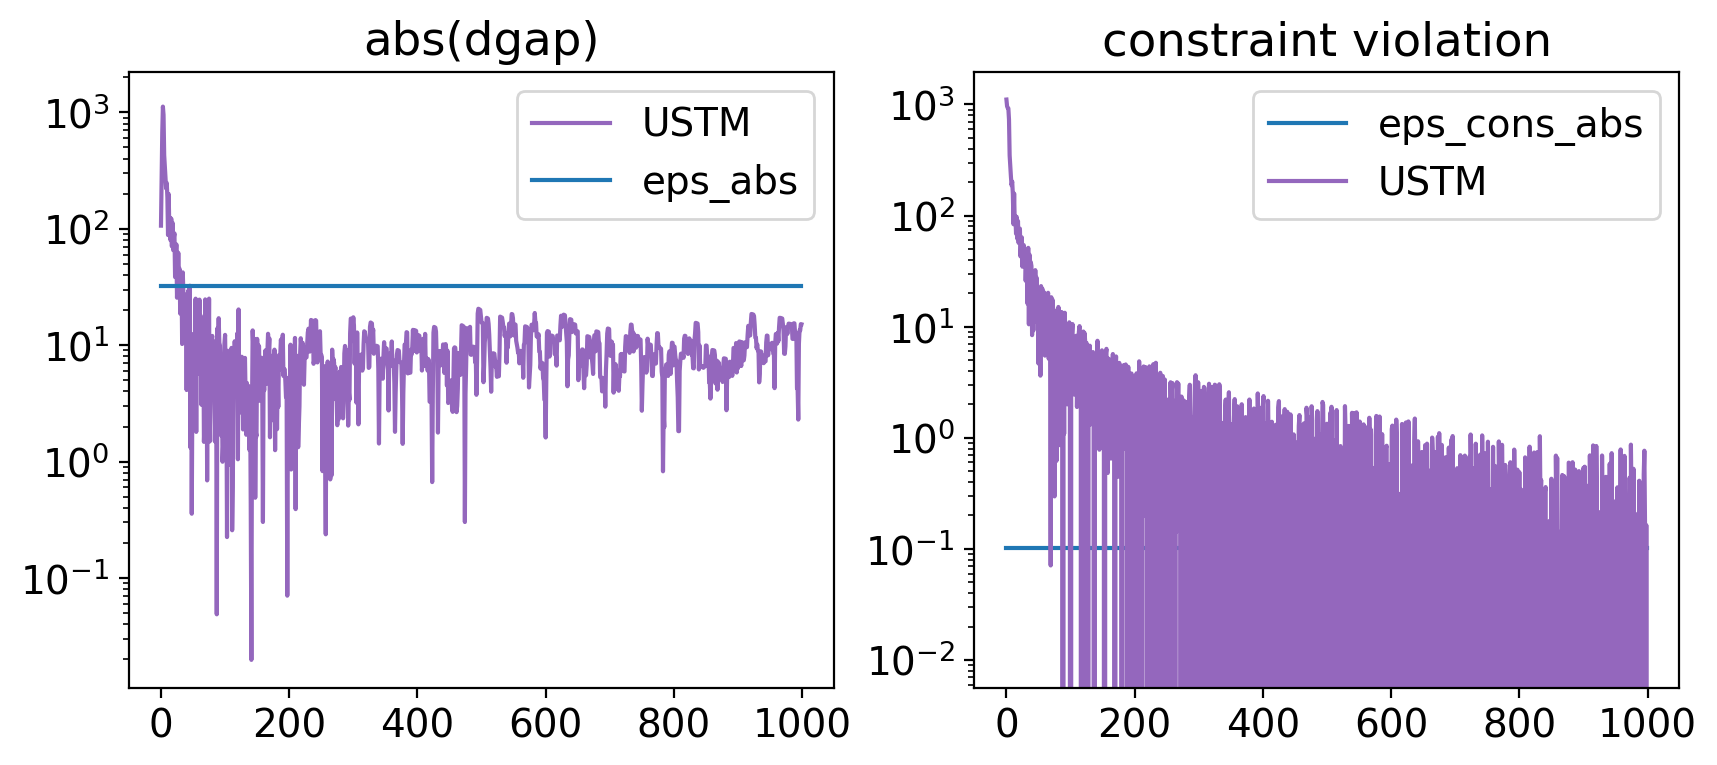

In [10]:
A_arr = np.array(A_log) 
plt.figure(figsize=(10,4))
plt.subplot(121)
dgap_abs = np.abs(dgap_log)
plt.plot(dgap_abs, c="C4", label="USTM")
plt.plot(np.ones(dgap_abs.size) * eps_abs, label="eps_abs")
plt.yscale("log")
plt.ylim(None, dgap_abs.max() * 2)
plt.title("abs(dgap)")
plt.legend()

plt.subplot(122)
plt.plot(np.ones(len(cons_log)) * eps_cons_abs, label="eps_cons_abs")
plt.plot(cons_log, c="C4", label="USTM")
# plt.plot(4 * R / A_arr + (2 * eps_abs / A_arr)) # actually, it is bound for 2-norm, while cons_log is 1-norm
# plt.ylim(np.min(cons_log) / 1.5, np.max(cons_log) * 2)
plt.title("constraint violation")
plt.yscale("log")
plt.legend()

print("average dgap:", np.mean(dgap_log))

0.0 0.0


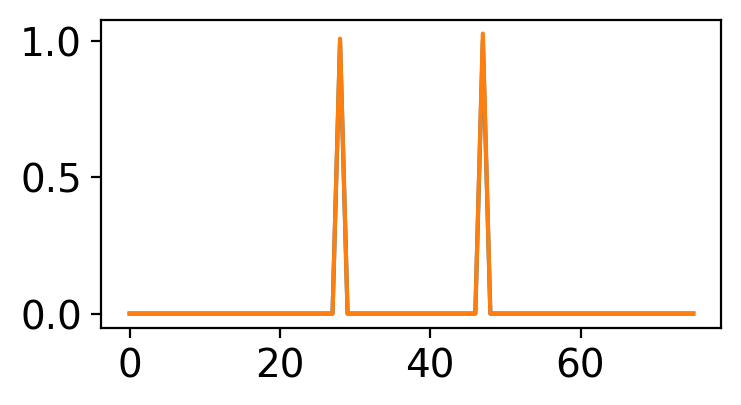

In [13]:
    _ = plt.figure(figsize=(4, 2)), plt.plot(dual_costs_cvx), plt.plot(dual_costs)
# print(model.primal(flows_cvx), model.primal(flows_e_ustm))
print(model.constraints_violation_l1(flows_cvx), model.constraints_violation_l1(flows_e_ustm))

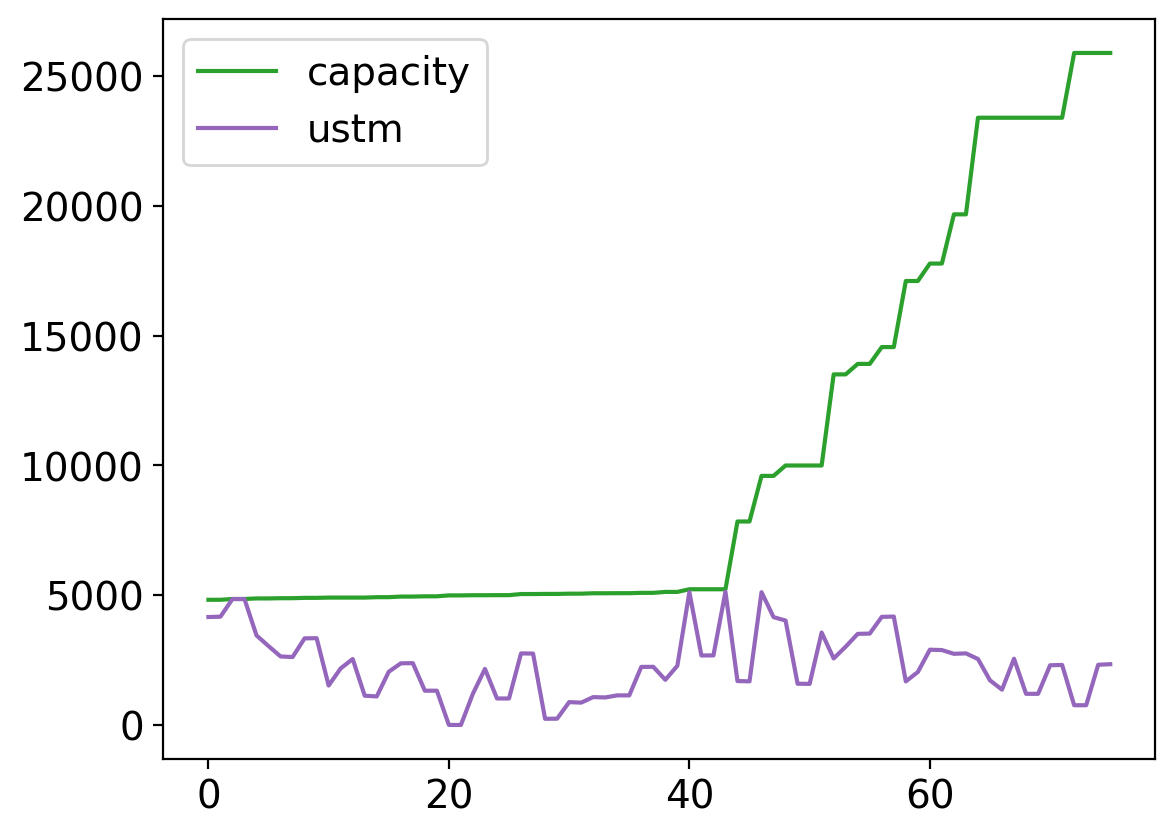

In [14]:
bws = model.graph.ep.bandwidths.a
order = bws.argsort()

plt.plot(bws[order], label="capacity", c='C2')
# plt.plot(flows_cvx[order], label="cvxpy", c="C1")
plt.plot(flows_e_ustm[order], label="ustm", c="C4")

plt.legend()

# Subgd

In [ ]:
%%time

# R = 10
dual_costs, flows_e_subgd, dgap_log, cons_log, optimal = subgd_mincost_mcf(model, R=10 * R, eps_abs=eps_abs, 
                                                                   eps_cons_abs=eps_cons_abs, max_iter=1000)
R = np.linalg.norm(dual_costs)
print(len(dgap_log), "iters")

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)
dgap_abs = np.abs(dgap_log)
plt.plot(np.ones(dgap_abs.size) * eps_abs, label="eps_abs")
plt.plot(dgap_abs, c="C3", label="subgd")
plt.legend()
plt.yscale("log")

plt.title("abs(dgap)")
plt.subplot(122)
plt.plot(np.ones(len(cons_log)) * eps_cons_abs, label="eps_cons_abs")
plt.plot(cons_log, c="C3", label="subgd")
plt.legend()
plt.title("constraint violation l1 norm")
plt.yscale("log")

print("average dgap:", np.mean(dgap_log))

In [ ]:
_ = plt.figure(figsize=(4, 2))
plt.plot(dual_costs_cvx, c="C1", label="dual var cvx")
plt.plot(dual_costs, c="C3", label="dual var subgd")
plt.legend()

In [ ]:
plt.plot(model.graph.ep.bandwidths.a, label="capacity", c="C2")
plt.plot(flows_cvx, label="cvxpy", c="C1")
plt.plot(flows_e_subgd, label="subgd", c="C3")
plt.title("link flows")
plt.xlabel("link index")

plt.legend()

# Compare SubGD and USTM

In [ ]:
%%time

traffic_mat = 0.9 * traffic_mat_max
_, dual_costs_cvx, _, _ = solve_min_cost_concurrent_flow(graph, traffic_mat, solver=cp.ECOS)
R = np.linalg.norm(dual_costs_cvx)

model = CapacityDualModel(graph, traffic_mat) 
subgd_times, subgd_iters, ustm_times, ustm_iters  = [], [], [], []
epss = np.logspace(-3.5, -1.5, 10)
res = {}
res[f"USTM"] = {"epss" : list(epss), "times": ustm_times, "iters": ustm_iters}
res[f"SubGD"] = {"epss" : list(epss), "times": subgd_times, "iters": subgd_iters}

for eps in epss:
    eps_abs_ = eps * mean_cost * mean_bw * graph.number_of_edges()
    eps_cons_abs_ = eps * mean_bw 
    
    t0 = time.time()
    w_arr, flows_res, dgap_log, cons_log, optimal = subgd_mincost_mcf(model, 10 * R, eps_abs_, eps_cons_abs_, max_time=2 * 60)
    print(f"subg: eps={eps}, niters={len(dgap_log)}")
    subgd_times.append(time.time()-t0)
    subgd_iters.append(len(dgap_log))
    
    t0 = time.time()
    w_arr, flows_weighted, dgap_log, cons_log, A_log, optimal = ustm_mincost_mcf(model, eps_abs_, eps_cons_abs_, max_time=2 * 60)
    ustm_times.append(time.time()-t0)
    print(f"ustm: eps={eps}, niters={len(dgap_log)}\n")
    ustm_iters.append(len(dgap_log))
    
    
# with open(f"results/ustm-vs-subgd.json", "w") as fp:
#     json.dump(res, fp)


In [ ]:
colors = {
    "USTM, eps=0.001": "C0",
    "USTM, eps=0.01": "C2",
    "USTM": "C0",
    "ECOS, eps=0.001": "C3",
    "ECOS, eps=0.01": "C5",
    "HIGHS, accurate": "C4",
    "SubGD": "C1",
 }

In [ ]:
with open(f"results/ustm-vs-subgd.json", "r") as fp:
    res = json.load(fp)
    
i = 0
for k, v in res.items():
    plt.plot(v["epss"], v["times"], label=k, c=colors[k])
    plt.scatter(v["epss"], v["times"], c=colors[k])
    i += 1
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.ylabel("time, s")
plt.xlabel("eps")
plt.gca().invert_xaxis()

plt.tight_layout()
plt.savefig("results/ustm_vs_subgd.pdf")


# USTM vs CVXpy

In [ ]:
time_limit = 10 * 60
# comment = "USTM rvalue mul 0.5->0.1, changed crit to avg bandwdths and costs, l1->l2"
comment = "10 points, USTM rvalue mul 0.5->0.1, changed crit to avg bandwdths and costs, COST SCALED BY MUL, l1->l2"

res = {"meta": {"network": network, "time_limit": time_limit, "description": comment}}

for eps in [1e-3, 1e-2]:
    mul_ls = np.linspace(0.01, 0.99, 10)

    print("USTM")
    cur_res = res[f"USTM, eps={eps}"] = {"eps": eps}
    records = cur_res["records"] = []
    
    muls, times, costs = [], [], []
    for mul in tqdm(mul_ls):
        eps_abs_ = eps * mean_cost * mean_bw * graph.number_of_edges() * mul
        eps_cons_abs_ = eps * mean_bw 
        model = CapacityDualModel(graph, traffic_mat * mul) 
        t0 = time.time()
        w_arr, flows_weighted, dgap_log, cons_log, A_log, optimal = ustm_mincost_mcf(
            model, eps_abs_, eps_cons_abs_, max_time=time_limit, max_iter=None)
        if optimal:
            records.append({"mul": mul, "time": time.time() - t0, "cost": model.primal(flows_weighted)})
            muls.append(mul)
            times.append(time.time() - t0)
            costs.append(model.primal(flows_weighted))

    plt.plot(muls, times, label=f"USTM, eps={eps: .3g}")
    print(f"cost err: {eps_abs_: .4g}, costs: {[round(float(x), 4) for x in costs]}, cons err: {eps_cons_abs_}")


    if network == "abilene":
        print("ECOS")
        cur_res = res[f"ECOS, eps={eps}"] = {"eps": eps}
        records = cur_res["records"] = []
        
        muls, times = [], []
        for mul in mul_ls:
            t0 = time.time()
            flows_cvx, dual_costs_cvx, _, _ = solve_min_cost_concurrent_flow(graph, traffic_mat * mul, solver="ECOS",
                                                                         abstol=eps_abs)

            if flows_cvx is not None:
                muls.append(mul), times.append(time.time() - t0)
                cost = float(flows_cvx.sum(axis=1) @ model.graph.ep.costs.a)
                records.append({"mul": mul, "time": time.time() - t0, "cost": cost})
        plt.plot(muls, times, label=f"ECOS, eps={eps: .3g}")

print("SCIPY")
cur_res = res[f"HIGHS, accurate"] = {}
records = cur_res["records"] = []

muls, times = [], []
for mul in tqdm(mul_ls):
    t0 = time.time()
    try:
        flows_cvx, dual_costs_cvx, _, _ = solve_min_cost_concurrent_flow(graph, traffic_mat * mul, solver=cp.SCIPY, 
                                                         scipy_options=dict(method="highs",
                                                                            time_limit=time_limit),)
        if flows_cvx is not None:
            muls.append(mul), times.append(time.time() - t0)
            cost = float(flows_cvx.sum(axis=1) @ model.graph.ep.costs.a)
            records.append({"mul": mul, "time": time.time() - t0, "cost": cost})
    except:
        pass

plt.plot(muls, times, label=f"scipy(highs), accurate")

# muls, times = [], []
# for mul in mul_ls:
#     t0 = time.time()
#     flows_cvx, dual_costs_cvx, _, _ = solve_min_cost_concurrent_flow(graph, traffic_mat * mul, solver="SCS", verbose=True, 
#                                                                   time_limit_secs=time_limit)

#     if flows_cvx is not None:
#         muls.append(mul), times.append(time.time() - t0)

# plt.plot(muls, times, label=f"SCS, accurate")

plt.legend()
plt.yscale("log")
plt.plot()

# with open(f"results/{network}-ustm-vs-cvxpy.json", "w") as fp:
#     json.dump(res, fp)
    


# Draw plots (USTM vs CVXpy)

In [ ]:
import pandas as pd

# uncomment to draw from saved results
# network = "Anaheim"
# network = "abilene"

with open(f"results/{network}-ustm-vs-cvxpy.json", "r") as fp:
    res = json.load(fp)
    
for k, v in res.items():
    if k != "meta":
        df = pd.DataFrame.from_records(v["records"])
        plt.plot(df["mul"], df.cost, label=k)
plt.ylabel("cost")
plt.xlabel("beta")
plt.title("pareto front")
plt.legend()


In [ ]:
for k, v in res.items():
    if k != "meta":
        df = pd.DataFrame.from_records(v["records"])
        plt.plot(df["mul"], df.time, label=k, c=colors[k])
        plt.scatter(df["mul"], df.time, c=colors[k])
    
plt.legend()
plt.yscale("log")
plt.xlabel("beta")
plt.ylabel("time, s")

plt.tight_layout()
# plt.savefig(f"results/{network}_ustm_vs_cvxpy.pdf")

### Benchmark graph-tool vs networkx

In [ ]:
nx_graph = graph
gt_graph = model.graph

from src.solvers.graph_utils.shortest_paths_gt import flows_on_shortest_gt
from src.solvers.graph_utils.shortest_paths_nx import flows_on_shortest_nx

In [ ]:
def benchmark_gt():
    weights = gt_graph.new_edge_property("double")
    weights.a = np.random.random(graph.number_of_edges())
    _ = flows_on_shortest_gt(gt_graph, traffic_mat, weights)
    
%timeit benchmark_gt()

In [ ]:
%timeit _ = flows_on_shortest_nx(nx_graph, traffic_mat, np.random.random(graph.number_of_edges()))